# Hackathon soyHenry Data Science 1ra Cohorte

Este hackathon es una instancia de evaluación, por lo cuál es INDIVIDUAL e OBLIGATORIO para los alumnos de Data Science de Henry. Se disponibilizará un google forms por dataset y pueden cargarse los resultados las veces que quieran. Es obligatorio que todos disponibilicen el código utilizado, para validar los modelos construídos. Esta es la solución propuesta por Jonathan Deiloff.

## Housing Dreams

¡Bienvenidos al primer dataset del Hackathon! En este primer desafío, nos ponemos en los zapatos del equipo de ML de la ficticia HouseDream, una empresa tech de Real Estate radicada en USA, recientemente fundada. Nos dedicamos a conseguir casas de ensueño nuestros usuarios, listadas o no, utilizando tecnología para matchear casas con usuarios.

### Descripción del Problema

Nuestro Team Lider nos pide que armemos un modelo para predecir el precio de una casa con el dataset recién llegado del área de Data Collection. Este dataset pertenece a la ciudad de Ames, Iowa, ciudad la cuál la empresa quiere agregar a la oferta disponible. 

Nuestra meta es plantear un modelo (o serie de ellos), correrlo y utilizar la métrica definida para testear su performance.

### Métrica a utilizar

Se utilizará para evaluar el desempeño del/los modelo/s la raíz cuadrada del error logarítmico medio, (RMSLE) por sus siglas en inglés.

$$ RMSLE=\sqrt{\frac{1}{n}\sum_{i=1}^n(\log (p_i + 1)-\log (a_i+1))^2}$$

siendo $p_i$ el valor predicho y $a_i$ el actual.

### Importación de librerías necesarias

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings(action="ignore") # Evita mostrar advertencias en las salidas de la ejecución de celdas.
pd.set_option('display.max_columns', None) # Elimina el límite de impresión de columnas

## EDA

Antes de realizar predicción alguna, es importante realizar el análisis exploratorio de los datos para entender bien los datos que nos ofrece el dataset y tomar mejores decisiones al trabajar con él.

In [63]:
# Ingesta de los archivos
train_data = pd.read_csv('house_train_raw.csv')
test_data = pd.read_csv('houses_test_raw.csv')

train = train_data
test = test_data

train_test_data = pd.concat([train, test],axis=0,ignore_index=True) # Une el set de entrenamiento con el de prueba para entrenar el modelo con más datos.
train_test_data.info() # Echamos un vistazo al dataset para comprobar que todo se haya creado correctamente

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

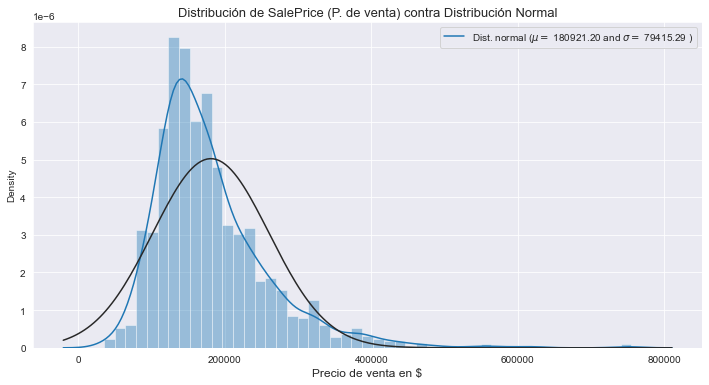

In [64]:
# Chequeamos que la columna objetivo tenga una distribución normal
(mu, sigma) = norm.fit(train['SalePrice'])
sns.set_style('darkgrid')
plt.figure(figsize = (12,6))
sns.distplot(train['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('Distribución de SalePrice (P. de venta) contra Distribución Normal', fontsize = 13)
plt.xlabel("Precio de venta en $", fontsize = 12)
plt.legend(['Dist. normal ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

Observamos que la distribución de la columna objetivo (precio de venta) no sigue una distribución normal, sino que está sesgada a la derecha

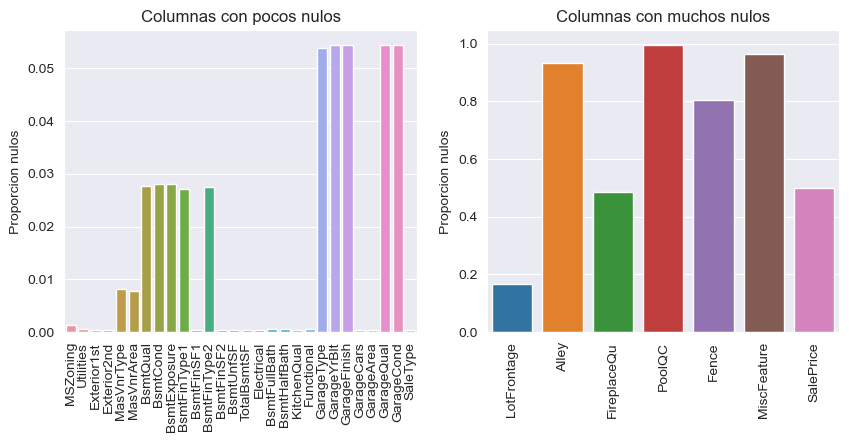

In [65]:
# Proporción de datos nulos/faltantes
porcentaje_nulos = train_test_data.isnull().sum() / len(train_test_data)
porcentaje_nulos = porcentaje_nulos[porcentaje_nulos.values>0]
porcentaje_nulos_bajos = porcentaje_nulos[porcentaje_nulos.values<=0.1]
porcentaje_nulos_altos = porcentaje_nulos[porcentaje_nulos.values>0.1]

fig = plt.figure(figsize=(10,4),dpi=100)
plt.subplot(1,2,1)
sns.barplot(x=porcentaje_nulos_bajos.index,y=porcentaje_nulos_bajos.values)
plt.title('Columnas con pocos nulos')
plt.ylabel('Proporcion nulos')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title('Columnas con muchos nulos')
plt.ylabel('Proporcion nulos')
sns.barplot(x=porcentaje_nulos_altos.index,y=porcentaje_nulos_altos.values)
plt.xticks(rotation=90);

Al comparar los resultados obtenidos con el diccionario de los datos de la documentación del proyecto, podemos notar que muchos de los nulos están distribuidos en columnas que dan datos categóricos, por ejemplo, 'FireplaceQu' y 'PoolQC' dan información sobre la calidad del hogar a leña o de la piscina, los nulos corresponden a la ausencia de ellos en las propiedades, por lo que no los podemos descartar.

### Matriz de correlación
Generamos un 'heatmap' para ver la correlación entre variables, es importante evitar que tengan mucha correlación entre ellas, pero que sí tengan correlación con la columna objetivo. Usamos el coeficiente de correlacion de Pearson (PCC) para corroborar la correlación entre variables.

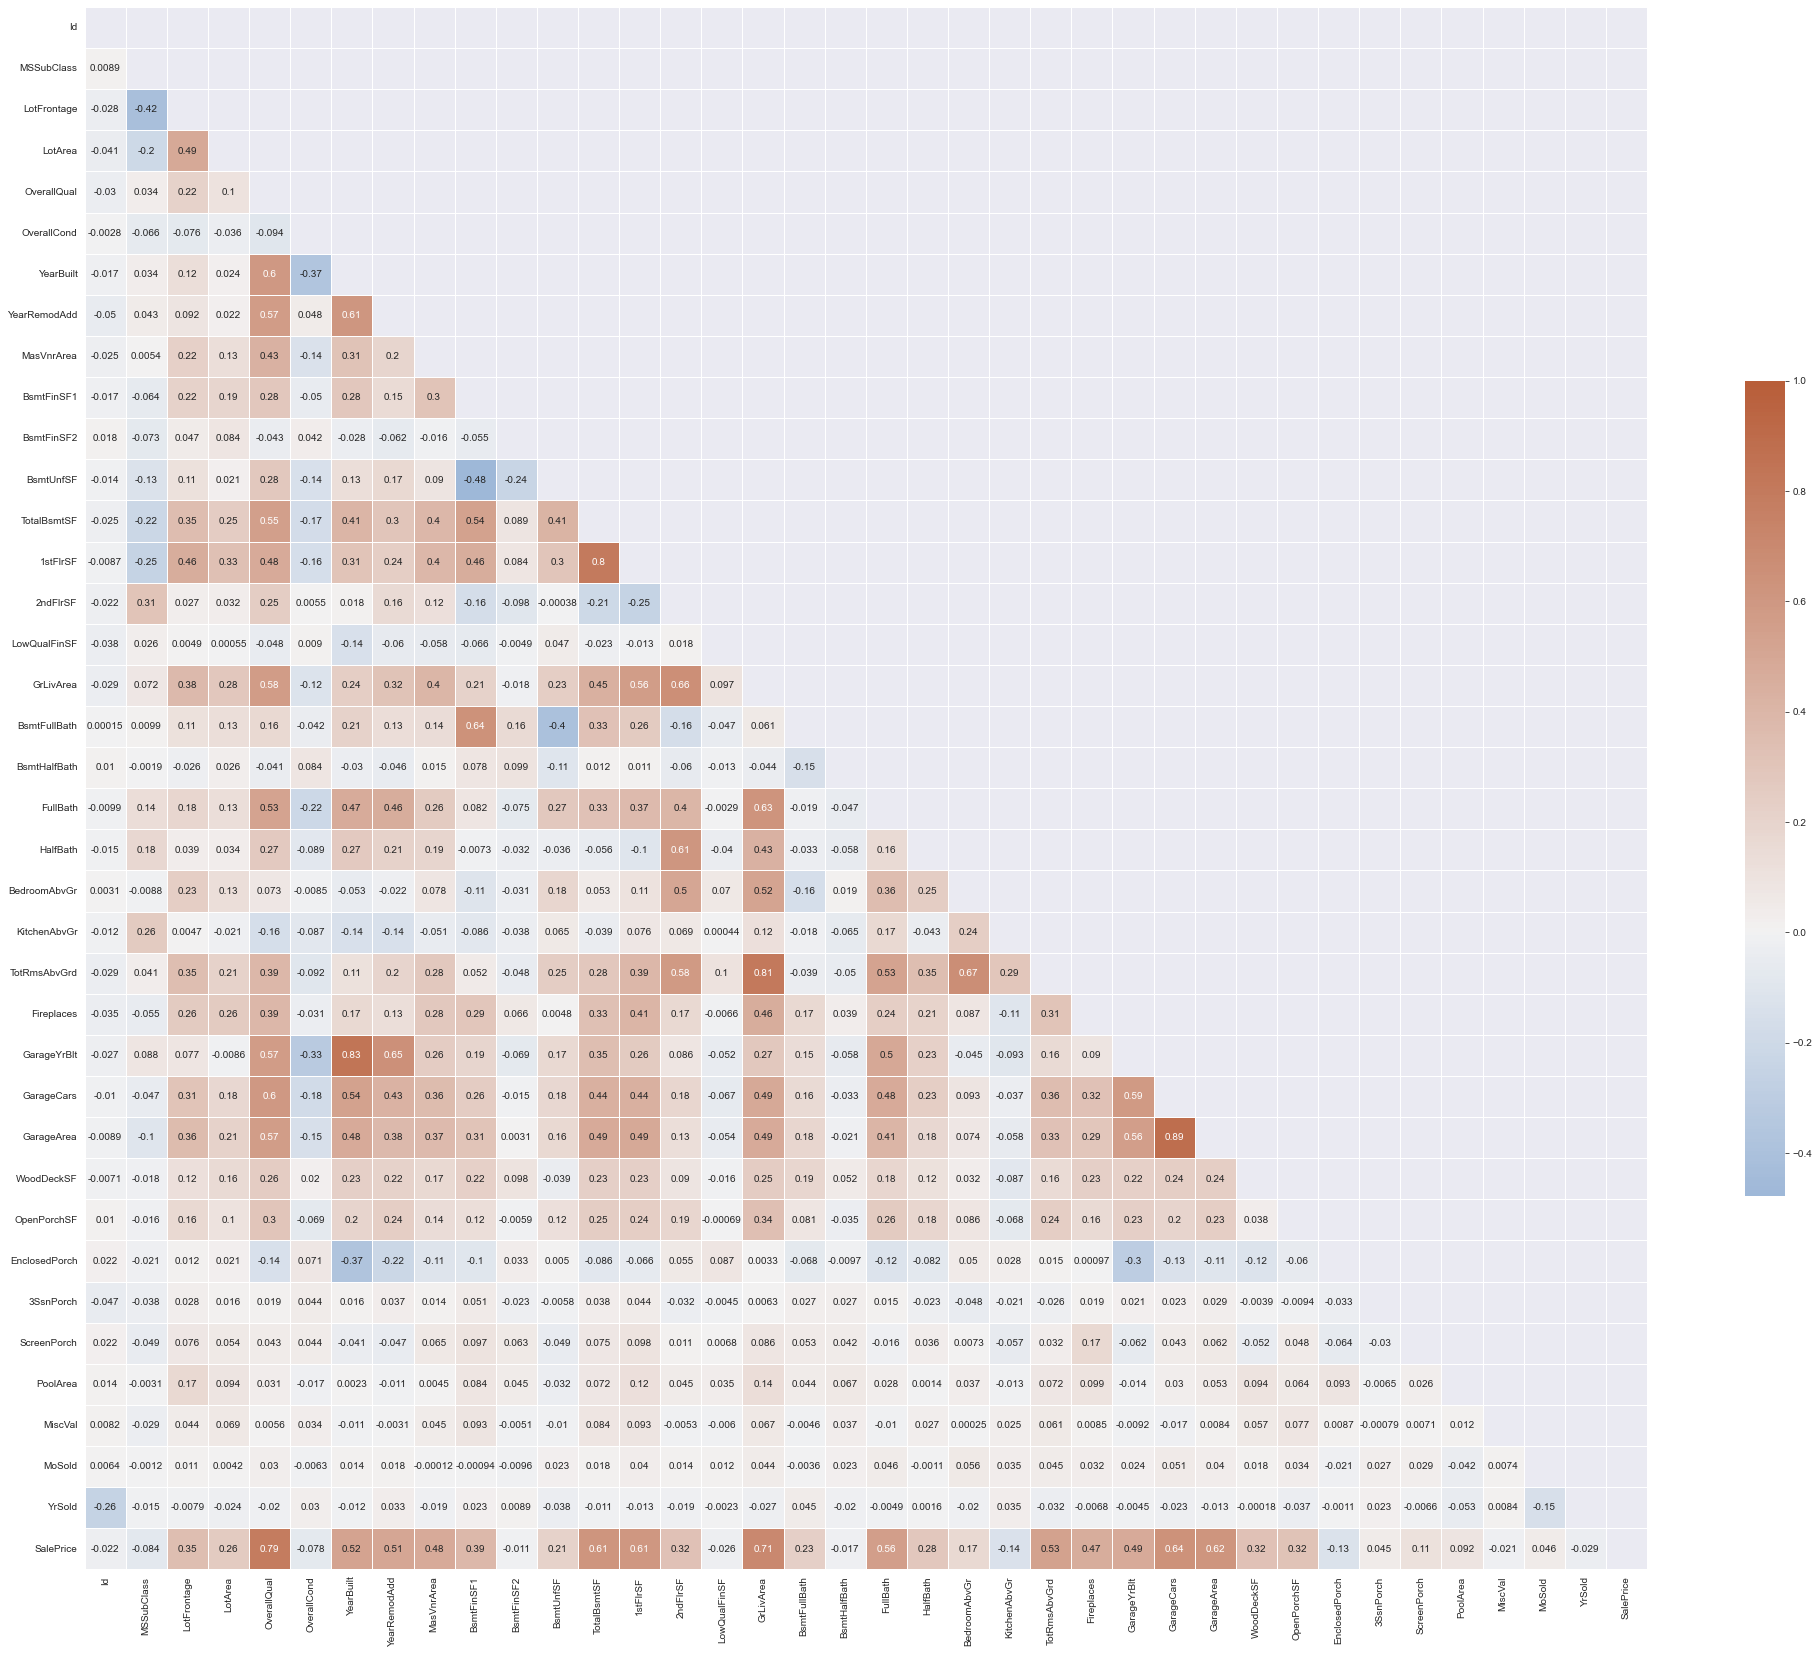

In [66]:
f, ax = plt.subplots(figsize=(35, 30))
mat = train_test_data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [67]:
mat['SalePrice']

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePr

Notamos una fuerte correlación entre SalePrice y OverallQual (calidad de la propiedad), GrLivArea (superficie sobre el nivel del suelo) y GarageCars (tamaño del garage).

##  Procesamiento de los datos

Terminado el EDA, con un mejor panorama sobre los datos, procedemos a procesar los datos antes de entrenar nuestro modelo de Machine Learning correctamente. Buscamos datos faltantes, codificamos las columnas categóricas para poder entrenar el modelo de Machine Learning (los modelos sólo entienden números) y normalizamos los datos para que estén en la misma escala y puedan ser comparables sin sesgos.


### Imputar valores faltantes
Se imputarán los valores faltantes, los numéricos se imputarán con la media para evitar alterar la varianza del dataset, los categóricos faltantes, se reemplazarán con la moda (el valor más frecuente). Los demás se imputarán según la descripción del diccionario de datos provisto por la documentación (por ejemplo, 'en PoolQC', si no hay pileta, deberia ser 'None'), que NO es lo mismo que un NaN.

In [68]:
# Imputar valores nulos, los que son numéricos con la media
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda val: val.fillna(val.mean()))
train['MiscFeature'] = train['MiscFeature'].replace(to_replace=['Gar2','Othr','TenC'],value='Otros')
train['MiscFeature'] = train['MiscFeature'].fillna(value='Otros')

test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda val: val.fillna(val.mean()))
test['MiscFeature'] = test['MiscFeature'].replace(to_replace=['Gar2','Othr','TenC'],value='Otros')
test['MiscFeature'] = test['MiscFeature'].fillna(value='Otros')


# Imputar valores faltantes con los valores moda, basado en el diccionario de datos otorgado.
train['MSZoning'] = train['MSZoning'].fillna(value='RL')
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['MasVnrType'] = train['MasVnrType'].fillna(value='None')
train['MasVnrArea'] = train['MasVnrArea'].fillna(value=0)
train[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = train[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna(value='None')
train[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = train[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(value=0)
train['Electrical'] = train['Electrical'].fillna(value='SBrkr')
train['KitchenQual'] = train['KitchenQual'].fillna(value='TA')
train['Functional'] = train['Functional'].fillna(value='Typ')
train["PoolQC"] = train["PoolQC"].fillna("None")
train["Alley"] = train["Alley"].fillna("None")
train['FireplaceQu'] = train['FireplaceQu'].fillna("None")
train['Fence'] = train['Fence'].fillna("None")
train[['GarageType','GarageFinish','GarageQual','GarageCond']] = train[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna(value='None')
train[['GarageCars','GarageArea']] = train[['GarageCars','GarageArea']].fillna(value=0)
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(value=1900)
train['SaleType'] = train['SaleType'].fillna(value='WD')
test['MSZoning'] = test['MSZoning'].fillna(value='RL')
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['MasVnrType'] = test['MasVnrType'].fillna(value='None')
test['MasVnrArea'] = test['MasVnrArea'].fillna(value=0)
test["PoolQC"] = test["PoolQC"].fillna("None")
test["Alley"] = test["Alley"].fillna("None")
test['FireplaceQu'] = test['FireplaceQu'].fillna("None")
test['Fence'] = test['Fence'].fillna("None")
test[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = test[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna(value='None')
test[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = test[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(value=0)
test['Electrical'] = test['Electrical'].fillna(value='SBrkr')
test['KitchenQual'] = test['KitchenQual'].fillna(value='TA')
test['Functional'] = test['Functional'].fillna(value='Typ')
test[['GarageType','GarageFinish','GarageQual','GarageCond']] = test[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna(value='None')
test[['GarageCars','GarageArea']] = test[['GarageCars','GarageArea']].fillna(value=0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(value=1900)
test['SaleType'] = test['SaleType'].fillna(value='WD')



## Escalamiento de los datos
Se escalan los datos para que se manejen entre valores similares todas las variables, para facilitar el aprendizaje de los algoritmos y con ello mejorar las métricas de rendimiento.

In [69]:
# Realizamos una transformación logarítmica de la columna objetivo.
train['SalePrice'] = np.log1p(train['SalePrice'])

# La transformación Log/BoxCox transforma datos sesgados. 
columnas_numericas = test.dtypes[test.dtypes != "object"].index

columnas_sesgadas = test[columnas_numericas].apply(lambda x: skew(x.dropna())) #compute skewness
columnas_sesgadas = columnas_sesgadas[columnas_sesgadas > 0.75]
columnas_sesgadas = columnas_sesgadas.index

lam = 0.15
for columna in columnas_sesgadas:
    train[columna] = boxcox1p(train[columna], lam) 
    test[columna] = boxcox1p(test[columna], lam)

## Preparación de los datos para poder entrenar modelos
Se unirán los dos datasets provistos, el de entrenamiento y el de testeo, para luego encodificar todas las columnas con valores categóricos con números para poder entrenar el modelo de ML (los modelos de ML requieren numeros como input), utilizando el método pd.get_dummies().

In [70]:
y = train['SalePrice']
train = train.drop('SalePrice',axis=1)

train_test_data = pd.concat([train, test],axis=0,ignore_index=True)
train_test_data = pd.get_dummies(train_test_data,drop_first=True)

X_train = train_test_data.iloc[:1460]
X_test = train_test_data.iloc[1460:]

## Modelado de Machine Learning

A continuación se crearán varios modelos de Machine Learning para luego apilarlos en un modelo solo. La idea es que al utilizar distintos tipos de modelos, se reducirá el sobreajuste de los modelos a los datos, ofreciendo un mejor resultado que cada modelo por separado. Los modelos elegidos son: xgboost (extreme gradient boosting, que va hallando el mínimo local avanzando continuamente en dirección opuesta al gradiente de la función en ese punto, para ir disminuyendo el error), ridgeCV (modelo lineal de regresion donde las variables independientes están muy correlacionadas), SVR (otro modelo lineal de regresión que separa los datos en clases distintas), gbr (gradient boosting regressor, similar al xgboost pero más simple), un random forest regressor (utiliza los 'random forest' de árboles de decisiones generados al azar y se va quedando con los más útiles para regresión lineal), por último, StackingCVRegressor apila todos los modelos en uno solo, usando xgboost como el regresor principal. Los valores de los hiperparámetros fueron buscados a mano, priorizando la minimización de la raíz cuadrada del error logarítmico medio.

In [71]:
# Se preparan todas las instancias de validación cruzada
kf = KFold(n_splits=12, random_state=335, shuffle=True) # Random state característico para poder reproducir resultados

# Modelo de XGBRegressor con varios hiperparametros probados manualmente, se usa como objetivo squaredlogerror para usar como métrica RMSLE según lo pedido.
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squaredlogerror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00008,
                       random_state=335)

# Valores de alphas para el modelo RidgeCV, elegidos a mano para regularizar el modelo, evitando sobreajuste.
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]

# RidgeCV con pipeline donde se escalan los datos con RobustScaler para que no sea tan afectado por outliers.
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor, con valores de hiperparámetros buscados a mano
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.0010, gamma=0.0004))

# Gradient Boosting Regressor, la función de error 'huber' combina error absoluto con error cuadrático.
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.012,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=335)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=335)

# Apila todos los modelos anteriores tomando sus predicciones para alimentar al regresor xgboost como el estimador final, utilizando validación cruzada para entrenar el modelo con distintos subsets de datos, ayudando a que se ajuste mejor.
stack = StackingCVRegressor(regressors=(xgboost, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
# Se entrena al modelo final con los datos.

stack.fit(np.array(X_train), np.array(y))

### Generación de la predicción

In [129]:
prediccion = stack.predict(np.array(X))

###  RMSLE, raíz cuadrada del error logarítmico medio

In [130]:
print(np.sqrt(mean_squared_log_error(y, prediccion)))

0.030649637244749662


## Generación del archivo con las predicciones

In [131]:
prediccion_df = pd.DataFrame(prediccion)
prediccion_df = prediccion_df.rename(columns={0:'pred'})
prediccion_df.to_csv("pred_test.csv", index=False)

In [133]:
print(prediccion_df.head())

        pred
0  12.016942
1  12.016942
2  12.016942
3  12.016942
4  12.016942
